## Chapter6: Movie Review Sentimental Analysis with LSTM

### 6.1 Library

In [1]:
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Using TensorFlow backend.


### 6.2 Sequence

**시퀀스 문제**는 머신러닝 문제 중 하나로, 모델에 입력할 특징 변수의 순서가 예측에 중요한 비중을 차지하는 문제다. 예는 다음과 같다.

- 자연어 처리 문제: 감성 분석, 기계 번역, 다음 단어 예측
- 시계열 예측

### 6.4  RNN

RNN의 원리는 인강이나 책을 찾아보기 바란다. 여기에 적기에는 너무 길다...

### 6.5 LSTM

아무튼 RNN의 경사소실문제를 해결하려고 나온 것이 LSTM이다. 장기 의존성을 고려한 모델이다.

### 6.6 IMDb Movie Review Dataset

IMDb 영화 리뷰 데이터는 리뷰 말뭉치 데이터셋이며, 각 리뷰에는 레이블이 달렸고, 1은 긍정, 0은 부정을 나타낸다. 케라스에서 준다.

In [2]:
from keras.datasets import imdb

In [3]:
train, test = imdb.load_data(index_from=3)
X_train, y_train = train
X_test, y_test = test

17465344/17464789 [==============================] - 32s 2us/step


In [4]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


단어를 숫자로 이미 인코딩해서 그렇다고 한다. 케라스에 내장된 딕셔너리를 사용해 단어로 다시 변환한다.

In [5]:
word_to_id = imdb.get_word_index()
word_to_id = {key:(value+3) for key, value in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
id_to_word = {value:key for key, value in word_to_id.items()}

1646592/1641221 [==============================] - 7s 4us/step


In [6]:
print(' '.join(id_to_word[id] for id in X_train[159]))

<START> a rating of 1 does not begin to express how dull depressing and relentlessly bad this movie is


In [7]:
print(y_train[159])

0


부정적인 리뷰가 튀어나왔다.

### 6.7 Word Embedding

단어를 컴퓨터에 입력시키려면 단순한 방법으로는 안된다. 그림은 화소의 픽셀 값으로 이미 디지털화가 되어 있지만 단어는 그렇지 않다.

이를 수학적으로 표현해주어야 한다. 인코딩을 해야하는데 단순한 인코딩은 안되고 임베딩 기법을 쓴다. 자세한 건 따로 알아보도록 하자. 암튼 좌표상에 올려놓는 것이다.

### 6.9 Modeling

모델의 아키텍쳐는 다음과 같다.

- 입력
- 임베딩 레이어
- LSTM 레이어
- 덴스 레이어
- 출력

#### 6.9.1 DATA

In [10]:
# num_words 인자를 통해 단어 수를 정하자. 10000개만 받자.

train, test = imdb.load_data(num_words=10000)
X_train, y_train = train
X_test, y_test = test

In [11]:
print(X_train.shape[0])
print(X_test.shape[0])

25000
25000


#### 6.9.2 Zero Padding

영화 리뷰의 길이가 각각 다르므로 입력 벡터의 크기도 다르다. 신경망은 정해진 크기의 벡터만 입력받을 수 있다.

영화 리뷰의 최대 길이를 maxlen 매개변수로 정의해 이 문제를 해결할 것이다.

maxlen 보다 긴 리뷰는 자르고, 짧은 리뷰는 0을 채울 수 있다. 이 과정을 zero padding이라고 한다.

In [12]:
from keras.preprocessing import sequence

In [13]:
X_train_padded = sequence.pad_sequences(X_train, maxlen=100)
X_test_padded = sequence.pad_sequences(X_test, maxlen=100)

In [15]:
print(X_train_padded.shape)
print(X_test_padded.shape)

(25000, 100)
(25000, 100)


100으로 길이를 맞췄다.

#### 6.9.3 Embedding Layer, LSTM Layer

In [16]:
from keras.models import Sequential

In [17]:
model=Sequential()

In [18]:
from keras.layers import Embedding, Dense, LSTM

Embedding 클래스는 다음 인자를 전달해야 한다.

- input_dim: 워드 임베딩 레이어의 입력 벡터 차원. 입력 벡터의 차원 수는 데이터셋에 있는 단어의 고유 개수와 동일해야 한다. 따라서 앞서 데이터 가져올 때 쓴 num_words 값을 그대로 쓴다.
- output_dim: 출력 벡터 차원. 이 값은 실험을 통해 신중히 결정해야 한다. 여기서는 128로 지정한다.

In [20]:
model.add(Embedding(input_dim=10000, output_dim=128))

LSTM 클래스에는 다음 인자를 전달해야 한다.

- units: LSTM레이어의 반복 유닛 수를 지정한다. 유닛이 많을수록 모델 복잡, 훈련 시간 증가, 과적합 우려. 여기선 128
- activation: 셀 상태와 은닉 상태의 활성화 함수. 디폴트는 tanh.
- recurrent_activation: 망각 게이트, 입력 게이트, 출력 게이트에 적용할 활성화 함수. 디폴트는 sigmoid

리커런트 액티베이션을 보면 세 개의 게이트에 각기 다른 활성화 함수를 쓸 수 없다. 케라스의 한계이기도 한데, 연구결과에 따르면 다르게 해도 그닥 좋지 않다는...

In [21]:
model.add(LSTM(units=128))

마지막으로 Dense 레이러를 추가한다. 긍부정을 분류해야 하기 때문에 sigmoid 쓴다.

In [22]:
model.add(Dense(units=1, activation='sigmoid'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


#### 6.9.4 Compile and fit

LSTM에는 어떤 옵티마이저가 적합한지 아직 명확한 정답이 없다. 경사 소실 문제와 경사 폭증 문제 또한 발생한다. 적당한 애들 써보며 비교하는 수 밖에 없다.

여기서는 sgd, adam, RMSprop 를 비교해보겠다.

In [24]:
# sgd 부터
Optimizer = 'SGD'

In [25]:
model.compile(loss='binary_crossentropy', optimizer=Optimizer)

In [26]:
# 에폭은 10 , 테스트 셋을 발리데이션으로 모델 훈련

scores = model.fit(x=X_train_padded, y=y_train,
                  batch_size=128, epochs=10,
                  validation_data=(X_test_padded, y_test))

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 153s 6ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/10
25000/25000 [==============================] - 164s 7ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/10
25000/25000 [==============================] - 176s 7ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 4/10
25000/25000 [==============================] - 210s 8ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 5/10
25000/25000 [==============================] - 237s 9ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 6/10
25000/25000 [==============================] - 226s 9ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 7/10
25000/25000 [==============================] - 202s 8ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 8/10
25000/25000 [==============================] - 165s 7ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 9/10
25000/25000 [==============================] - 139s 6ms/step - loss: 0.6927 - val_loss: 0.6

옵티마이저별로 모델을 만들어 비교하기 위해 함수로 만들어 놓자.

In [31]:
def train_model(Optimizer, X_train, y_train, X_val, y_val):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128))
    model.add(LSTM(units=128))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Optimizer, metrics=['accuracy'])
    scores = model.fit(X_train, y_train, batch_size=128, epochs=10,
                      validation_data=(X_val, y_val),
                      verbose=0)
    return scores, model

In [32]:
# RMSprop 로 돌리고
RMS_score, RMS_model = train_model(Optimizer = 'RMSprop',
                                    X_train = X_train_padded,
                                    y_train = y_train,
                                    X_val = X_test_padded,
                                    y_val = y_test)

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [33]:
# adam으로 돌리고
adam_score, adam_model = train_model(Optimizer = 'adam',
                                    X_train = X_train_padded,
                                    y_train = y_train,
                                    X_val = X_test_padded,
                                    y_val = y_test)

In [36]:
# adam으로 돌리고
sgd_score, sgd_model = train_model(Optimizer = 'sgd',
                                    X_train = X_train_padded,
                                    y_train = y_train,
                                    X_val = X_test_padded,
                                    y_val = y_test)

In [39]:
sgd_score.history

{'val_loss': [0.6932626075935364,
  0.693202345790863,
  0.693146848487854,
  0.6930889930725098,
  0.6930312922477723,
  0.6929755427742005,
  0.6929188419723511,
  0.6928623648452759,
  0.6928069508171082,
  0.6927501468849182],
 'val_accuracy': [0.4979200065135956,
  0.503279983997345,
  0.5064799785614014,
  0.5128399729728699,
  0.5133600234985352,
  0.5196400284767151,
  0.5236799716949463,
  0.5253199934959412,
  0.5298799872398376,
  0.533079981803894],
 'loss': [0.6933092942428589,
  0.6932621933937073,
  0.6932021012687684,
  0.6931471618652344,
  0.6930725429344178,
  0.6930154277801513,
  0.6929578516578674,
  0.692897640838623,
  0.6928360307693482,
  0.6927731255149842],
 'accuracy': [0.49216,
  0.49036,
  0.49888,
  0.5002,
  0.50632,
  0.5092,
  0.51484,
  0.51936,
  0.52192,
  0.5298]}

## 6.10 Evaluation

각 모델의 에폭별 검증 정확도를 차트로 그려보자.

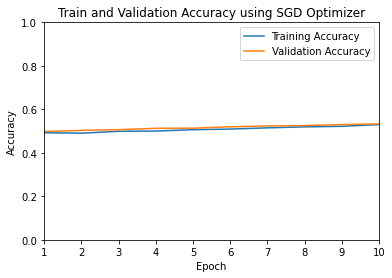

In [40]:
plt.plot(range(1, 11), sgd_score.history['accuracy'], label="Training Accuracy")
plt.plot(range(1, 11), sgd_score.history['val_accuracy'], label="Validation Accuracy")
plt.axis([1, 10, 0, 1])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy using SGD Optimizer")
plt.legend()
plt.show()

sgd는 50% 부근에서 능선을 탄다. 훈련이 제대로 되고 있지 않는다는 뜻이다.

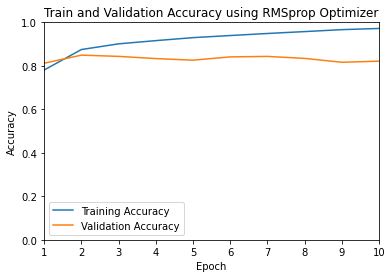

In [41]:
plt.plot(range(1, 11), RMS_score.history['accuracy'], label="Training Accuracy")
plt.plot(range(1, 11), RMS_score.history['val_accuracy'], label="Validation Accuracy")
plt.axis([1, 10, 0, 1])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy using RMSprop Optimizer")
plt.legend()
plt.show()

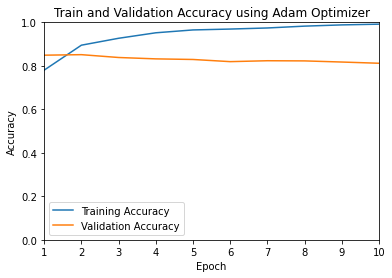

In [42]:
plt.plot(range(1, 11), adam_score.history['accuracy'], label="Training Accuracy")
plt.plot(range(1, 11), adam_score.history['val_accuracy'], label="Validation Accuracy")
plt.axis([1, 10, 0, 1])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy using Adam Optimizer")
plt.legend()
plt.show()

adam은 매우 높은 스코어를 보였으나, val 과 격차가 크다. 과대적합의 위험이 있다.

#### RMSprop 로 확정!

### 6.10.1 Confusion Matrix

예, CM으로 한 번 확인하겠습니다.

In [43]:
from sklearn.metrics import confusion_matrix

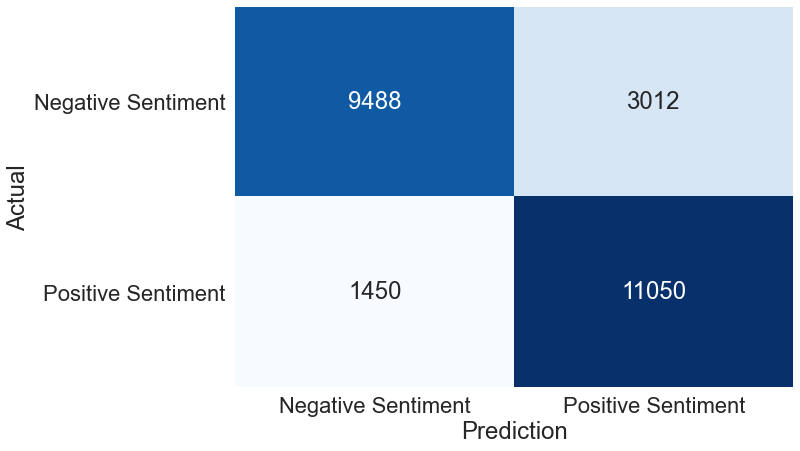

In [45]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=2)
y_test_pred = RMS_model.predict_classes(X_test_padded)
c_matrix = confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(c_matrix,
                 annot=True,
                 xticklabels=["Negative Sentiment", "Positive Sentiment"],
                 yticklabels=["Negative Sentiment", "Positive Sentiment"],
                 cbar=False,
                 cmap="Blues",
                 fmt="g")
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.show()